In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import math

In [61]:
from collections import defaultdict

In [43]:
class Blackjack_env:
    """
    env will be an interface with the following methods:
    start: return a starting state - (dealer first card, sum of player hand, usable ace)
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['h', 's']
    
    def evaluate_hand(self, cards):
        value = sum(cards)
        if value > 21:
            num_of_ace = sum([card == 11 for card in cards])
            for i in range(num_of_ace):
                value -= 10
                if value <= 21:
                    break
        return value
    
    def has_usable_ace(self):
        if not 11 in self.player:
            return False
        value = sum(self.player)
        if value > 21:
            num_of_ace = sum([card == 11 for card in self.player])
            for i in range(num_of_ace):
                value -= 10
                if value <= 21:
                    ace_left = num_of_ace - i - 1
                    return ace_left > 0
            return False
        else:
            return True
    
    def get_state(self):
        return self.dealer[0], self.evaluate_hand(self.player), self.has_usable_ace()
    
    def start(self):
        player = 21
        dealer = 21
        while player == 21 or dealer == 21:
            self.dealer = np.random.randint(2, 12, size=2)
            self.player = np.random.randint(2, 12, size=2)
            player = self.evaluate_hand(self.player)
            dealer = self.evaluate_hand(self.dealer)
        return self.get_state()
    
    def dealer_act(self):
        while(self.evaluate_hand(self.dealer) < 17):
            self.dealer = np.append(self.dealer, values=np.random.randint(2, 12))

    def act(self, action):
        if action == 'h':
            self.player = np.append(self.player, values=np.random.randint(2,12))
            if self.evaluate_hand(self.player) > 21:
                return self.get_state(), -1, True
            else:
                return self.get_state(), 0, False
        elif action == 's':
            self.dealer_act()
            dealer_hand = self.evaluate_hand(self.dealer)
            player_hand = self.evaluate_hand(self.player)
            if dealer_hand > 21:
                return self.get_state(), 1, True
            elif dealer_hand == player_hand:
                return self.get_state(), 0, True
            elif dealer_hand > player_hand:
                return self.get_state(), -1, True
            else:
                return self.get_state(), 1, True
        else:
            raise("Invalid action")
    
        

In [44]:
env = Blackjack_env()

In [45]:
env.player = [11, 11, 11, 2]
env.evaluate_hand(env.player)

15

In [58]:
env.start()

(9, 11, False)

In [59]:
env.act('h')

((9, 21, False), 0, False)

In [60]:
env.act('s')

((9, 21, False), 1, True)

In [57]:
env.dealer

array([5, 5, 2, 7])

In [55]:
env.player

array([ 8,  9, 11])

In [71]:
class MCAgent:
    def __init__(self, env, policy, discount=1):
        self.env = env
        self.policy = policy
        self.actions = env.actions
        self.V = defaultdict(int)
        self.returns = defaultdict(list)
        self.discount = discount
    
    def evaluate(self, episodes):
        for i in range(episodes):
            G = {}
            step_since_visit = {}
            state = env.start()
            is_end = False
            while not is_end:
                action = self.policy(state)
                next_state, reward, is_end = self.env.act(action)
                if not state in G:
                    G[state] = 0
                    step_since_visit[state] = -1
                for key in G.keys():
                    step_since_visit[key] += 1
                    G[key] += (self.discount ** step_since_visit[key]) * reward
                state = next_state
            for state, g in G.items():
                self.returns[state].append(g)
                self.V[state] = np.mean(self.returns[state])
                

In [77]:
bj_agent = MCAgent(env, lambda state: 'h' if state[1] < 20 else 's')

In [78]:
bj_agent.evaluate(10000)

In [96]:
X, Y = np.meshgrid(range(1, 12), range(12, 22)) # X is dealer, Y is player sum
zs_no = []
zs_yes = []
for x,y in zip(np.ravel(X), np.ravel(Y)):
    dealer = 11 if x == 1 else x
    zs_no.append(bj_agent.V[(dealer, y, False)])
    zs_yes.append(bj_agent.V[(dealer, y, True)])
Z_no = np.array(zs_no).reshape(X.shape)
Z_yes = np.array(zs_yes).reshape(X.shape)

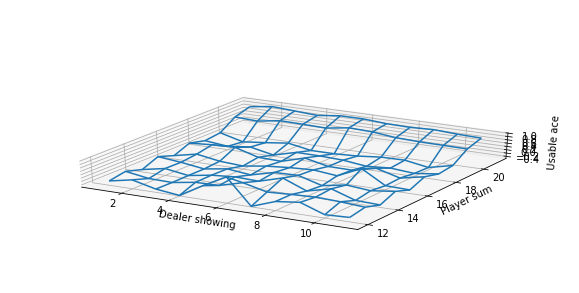

In [126]:
from mpl_toolkits.mplot3d import Axes3D  
from mpl_toolkits.mplot3d import proj3d

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=0.2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.get_proj=short_proj
ax.plot_wireframe(X, Y, Z_yes)

ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('Usable ace')
plt.show()

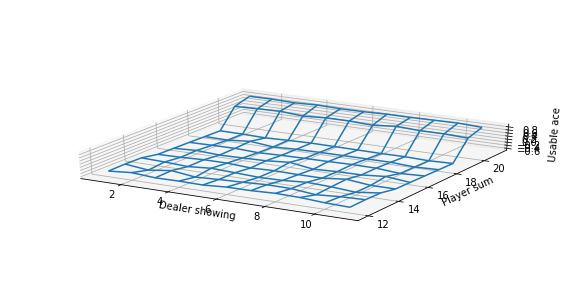

In [125]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.get_proj=short_proj
ax.plot_wireframe(X, Y, Z_no)

ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('Unusable ace')
plt.show()

In [127]:
bj_agent.evaluate(500000-10000)

In [142]:
X, Y = np.meshgrid(range(1, 11), range(12, 22)) # X is dealer, Y is player sum
zs_no = []
zs_yes = []
for x,y in zip(np.ravel(X), np.ravel(Y)):
    dealer = 11 if x == 1 else x
    zs_no.append(bj_agent.V[(dealer, y, False)])
    zs_yes.append(bj_agent.V[(dealer, y, True)])
Z_no = np.array(zs_no).reshape(X.shape)
Z_yes = np.array(zs_yes).reshape(X.shape)

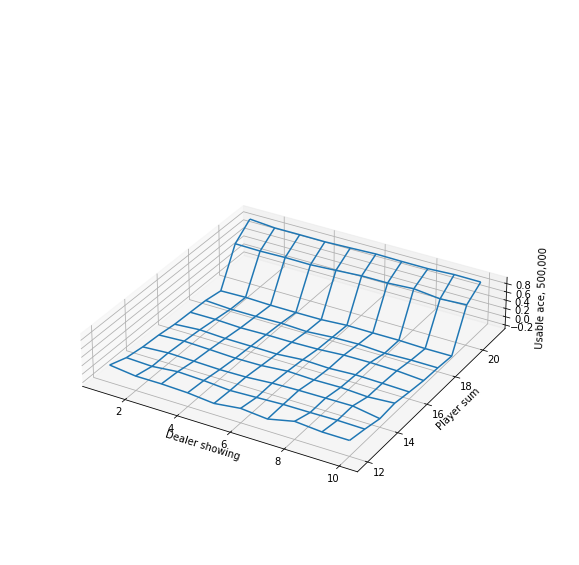

In [143]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.get_proj=short_proj
ax.plot_wireframe(X, Y, Z_yes)

ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('Usable ace, 500,000')
plt.show()

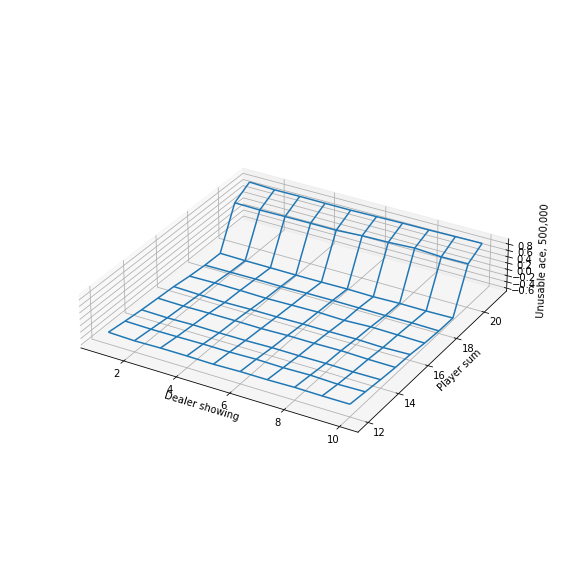

In [144]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.get_proj=short_proj
ax.plot_wireframe(X, Y, Z_no)

ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('Unusable ace, 500,000')
plt.show()

In [147]:
bj_agent.V[(3, 21, False)]

0.87339699863574349